### Import Libraries

In [1]:
# Detection을 위한 Tensorflow 모듈 설치
import tensorflow as tf
import tensorflow_hub as hub
import torch

# 이미지 시각화를 위한 모듈
import matplotlib.pyplot as plt #차트 그리기
import tempfile # 임시 파일/디렉터리 생성 
from six.moves.urllib.request import urlopen # url처리 (six: python2, 3 동시처리 가능한 모듈)
from six import BytesIO #데이터를 BytesIO로 읽은 뒤 이미지 Open

# For drawing onto the image. 배열
import numpy as np

# 파이썬 이미지 처리 pkg
from PIL import Image # 이미지 생성, 불러오기 등 제공
from PIL import ImageColor # color table 제공
from PIL import ImageDraw # 이미지에 텍스트 쓰기
from PIL import ImageFont # 이미지 내 폰트 설정
from PIL import ImageOps # 이미지 변형 

import time # 시간측정을 위한 함수

import warnings
warnings.filterwarnings('ignore')

import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### GPU

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'device name: {torch.cuda.get_device_name(0)}')

Using cuda device
device name: Quadro RTX 4000 with Max-Q Design


In [3]:
# Tensorflow GPU 체크
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0



### Version Checking

In [4]:
import sys
print(sys.version)

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


In [5]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.9.1


### Define Functions - Bounding Box & Detector

In [8]:
# 이미지 내 bounding box 생성
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):

  # 이미지에 bounding box 좌표 설정 
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size # 이미지 원본 사이즈
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  
  # bounding box 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)   
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list] # box string 높이가 이미지 높이 초과 시, 하단에 폰트 삽입
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights) # 각 strings에 0.05 마진

 # 각 bounding box의 top 좌표가 전체 string height보다 크다면, 
 # string을 bounding box위로 보내고, 아니면 bounding box 아래에 삽입
  if top > total_display_str_height: text_bottom = top
  else: text_bottom = top + total_display_str_height

  # list를 역방향으로 바꾸고, 아래에서 위로 출력 
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str, fill="black", font=font)
    text_bottom -= text_height - 2 * margin

In [9]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
#   """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())   # Corlor Library 호출

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):   # 이미지에 표시할 Bbox의 수를 최대 10개로 제한. 단, Detected Box가 10개 미만이면 딱 그만큼만 표현
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),   # Car : 21% 이런 형식으로 Printing 지정
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]               # 랜덤하게 색 지정
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))

  return image

In [10]:
# 최종 이미지 출력
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [11]:
def load_img(path):
  img = tf.io.read_file(path)   # tf로 파일 읽기 
  img = tf.image.decode_jpeg(img, channels=3)   # 파일로부터 jpeg read
  return img

In [12]:
# 사용모듈과 img path를 통해 detection 실행
def run_detector(detector, path):
  img = load_img(path) #image 불러오기
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...] #tf.float32로 img 변형
  result = detector(converted_img) #변형된 타입의 이미지를 detection
  result = {key:value.numpy() for key,value in result.items()}

  # 이미지 내 박스로 entity 및 socres를 추가하여 출력
  image_with_boxes = draw_boxes(img.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])
  display_image(image_with_boxes)

### Define Module/Detector

In [13]:
module_handle1 = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" # FasterRCNN+InceptionResNet V2: 정확도 높음 
module_handle2 = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"  # ssd+mobilenet v2: 빠르지만 정확도가 낮음

detector_faster_Rcnn = hub.load(module_handle1).signatures['default'] #detector에 사용할 모듈 저장
detector_ssd = hub.load(module_handle2).signatures['default'] #detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Image 지정

In [14]:
downloaded_image_path = 'C:\\Users\\SVhd08\\repos\\Practice\\KITTI_image.jpg'

### Two-Stage Obejct Detection : Faster R-CNN

Font not found, using default font.


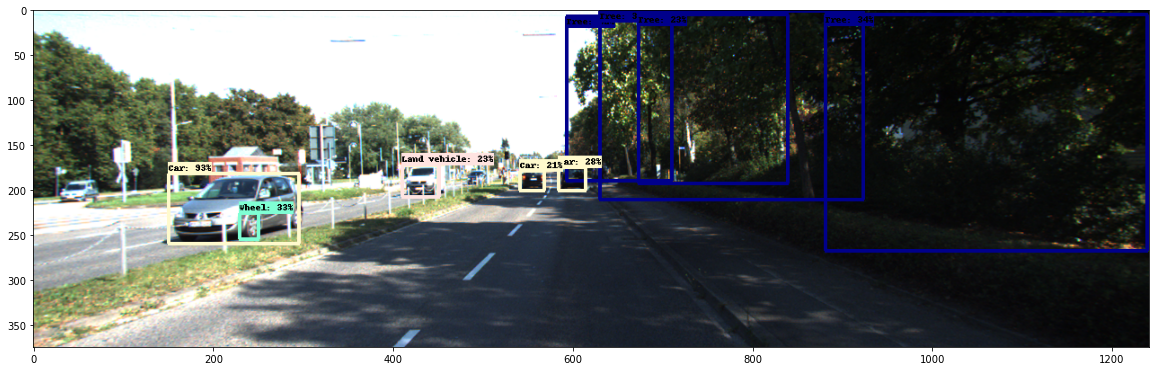

In [15]:
run_detector(detector_faster_Rcnn, downloaded_image_path)

### One-Stage Obejct Detection : SSD

Font not found, using default font.


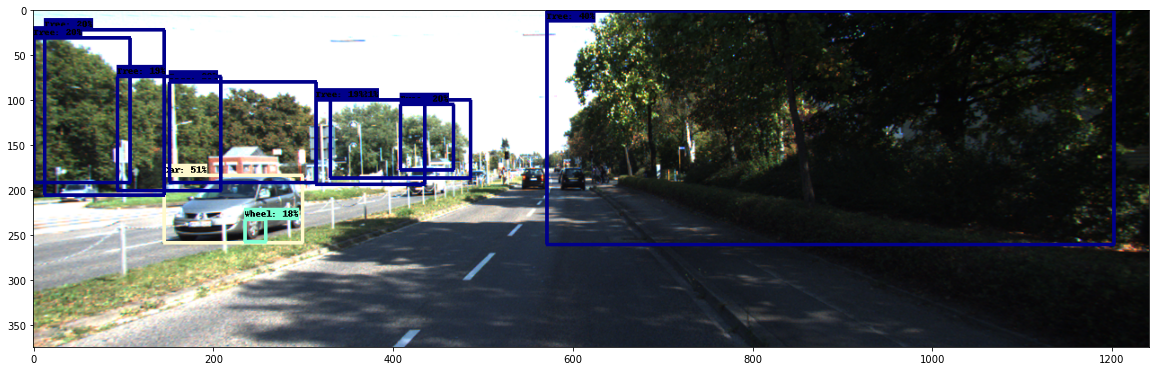

In [16]:
run_detector(detector_ssd, downloaded_image_path)